<a href="https://colab.research.google.com/github/abia200304/Distinct-Vehicle-Flow-Prediction-/blob/main/GRU_pems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip -o /content/my_pems_data.zip

Archive:  /content/my_pems_data.zip
   creating: my_pems_data/
  inflating: my_pems_data/pems_station_500011021_flow_04-01-2024_0600_to_04-07-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-08-2024_0600_to_04-14-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-15-2024_0600_to_04-21-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-22-2024_0600_to_04-28-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-29-2024_0600_to_05-05-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-06-2024_0600_to_05-12-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-13-2024_0600_to_05-19-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-20-2024_0600_to_05-26-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-27-2024_0600_to_06-02-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_06-03-2024_0600_to_06-09-202

In [ ]:
from glob import glob
import pandas as pd
import numpy as np

file_paths = glob('/content/my_pems_data/*.csv')
all_data = []

for file in file_paths:
    try:
        df = pd.read_csv(file, delimiter='\t')
        df.columns = df.columns.str.strip()
        if 'Flow (Veh/5 Minutes)' in df.columns and 'Truck Flow (Veh/5 Minutes)' in df.columns:
            all_data.append(df[['Flow (Veh/5 Minutes)', 'Truck Flow (Veh/5 Minutes)']])
        else:
            print(f"Skipping {file}: Required columns not found")
    except Exception as e:
        print(f"Error reading {file}: {e}")


In [ ]:
combined_df = pd.concat(all_data, ignore_index=True)
print(combined_df.shape)

(22824, 2)


In [ ]:
def process_traffic_data(df):

    processed_df = df.copy()

    processed_df = processed_df.rename(columns={
        'Flow (Veh/5 Minutes)': 'total_flow',
        'Truck Flow (Veh/5 Minutes)': 'truck_flow'
    })

    if 'total_flow' not in processed_df.columns or 'truck_flow' not in processed_df.columns:
        print("Error: Renaming of columns failed. Check original column names.")
        return None

    # Calculate Non-Truck Flow = Total Flow - Truck Flow
    processed_df['non_truck_flow'] = processed_df['total_flow'] - processed_df['truck_flow']

    # Handle any negative values
    negative_mask = processed_df['non_truck_flow'] < 0
    if negative_mask.sum() > 0:
        print(f"⚠️ Warning: {negative_mask.sum()} rows have negative non-truck flow values")
        processed_df.loc[negative_mask, 'non_truck_flow'] = 0

    # Add time-based features
    processed_df['time_index'] = range(len(processed_df))

    return processed_df


In [ ]:
processed_df = process_traffic_data(combined_df)


In [ ]:
display(processed_df)
print(processed_df.shape)

,total_flow,truck_flow,non_truck_flow,time_index
0,22.0,0.0,22.0,0
1,27.0,0.0,27.0,1
2,29.0,0.0,29.0,2
3,18.0,0.0,18.0,3
4,14.0,0.0,14.0,4
...,...,...,...,...
22819,23.0,0.0,23.0,22819
22820,48.0,0.0,48.0,22820
22821,25.0,0.0,25.0,22821
22822,29.0,0.0,29.0,22822


(22824, 4)


In [ ]:

processed_df.columns

Index(['total_flow', 'truck_flow', 'non_truck_flow', 'time_index'], dtype='object')

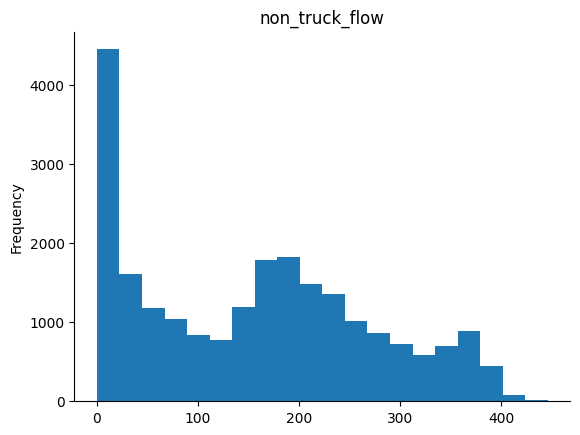

In [ ]:
from matplotlib import pyplot as plt
processed_df['non_truck_flow'].plot(kind='hist', bins=20, title='non_truck_flow')
plt.gca().spines[['top', 'right',]].set_visible(False)

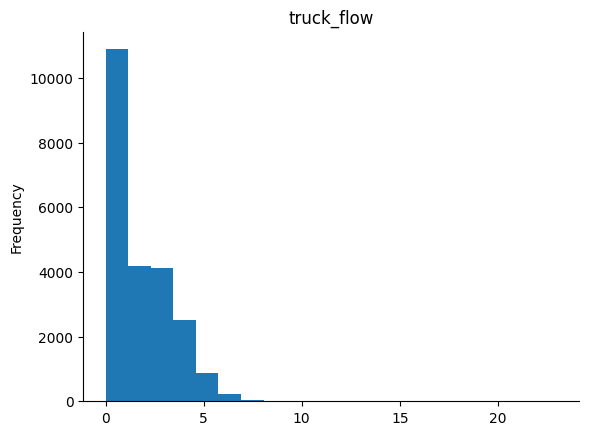

In [ ]:
from matplotlib import pyplot as plt
processed_df['truck_flow'].plot(kind='hist', bins=20, title='truck_flow')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
column_1_data = processed_df['truck_flow']
column_2_data = processed_df['non_truck_flow']

In [ ]:
coloumn_1_data=np.array(column_1_data)
coloumn_2_data=np.array(column_2_data)

In [ ]:
column1_data=coloumn_1_data.reshape(-1,1)
column2_data =coloumn_2_data.reshape(-1,1)

In [ ]:

data = np.concatenate([ column1_data,column2_data],axis =1)
print(data.shape)

(22824, 2)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scalar=MinMaxScaler((0,1))
scaled_data=scalar.fit_transform(data)

In [ ]:
scaled_data.shape

(22824, 2)

In [ ]:
def create_dataset(dataset, time_step):
    X, Y = [], []
    for i in range(len(dataset)-time_step):
        a = dataset[i:(i+time_step), :]
        X.append(a)
        Y.append(dataset[i + time_step, :])
    return np.array(X), np.array(Y)
time_step = 15
X, Y= create_dataset(scaled_data, time_step)
print(X.shape)
print(Y.shape)

(22809, 15, 2)
(22809, 2)


In [ ]:
X_train=X[:int(0.8*len(X))]
y_train = Y[:int(0.8*len(Y))].reshape(-1,2)
X_test = X[int(0.8*len(X)):]
y_test = Y[int(0.8*len(Y)):].reshape(-1,2)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(18247, 15, 2)
(18247, 2)
(4562, 15, 2)
(4562, 2)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense,Dropout
from tensorflow.keras.optimizers import Adam
from keras import regularizers

# model = Sequential()
# model.add(GRU(units=50, return_sequences=True, input_shape=(15,2)))
# model.add(GRU(units=50))
# model.add(Dense(units=2, kernel_regularizer=regularizers.l2(0.1)))

# model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# model.summary()

model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(15, 2)))
model.add(Dropout(0.2))
model.add(GRU(units=50, return_sequences=True)) # Added return_sequences=True here
model.add(Dropout(0.2))
model.add(GRU(units=50, return_sequences=True)) # This GRU layer needs return_sequences=True
model.add(Dropout(0.2))
model.add(GRU(units=50, return_sequences=False)) # The last GRU layer before Dense should not return sequences
model.add(Dropout(0.2))

model.add(Dense(units=2, kernel_regularizer=regularizers.l2(0.1)))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 15, 50)         │         8,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 15, 50)         │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 15, 50)         │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,102 (211.34 KB)

 Trainable params: 54,102 (211.34 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history=model.fit(X_train,y_train,validation_split=0.15,epochs=50,verbose=1)

Epoch 1/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.1580 - val_loss: 0.0066
Epoch 2/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.0047 - val_loss: 0.0036
Epoch 3/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 4/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 5/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 6/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 7/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 8/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 9/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 10/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 11/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 12/50
485/485 ━━━━━━━━━━

In [ ]:
model.save('gru_model.keras')

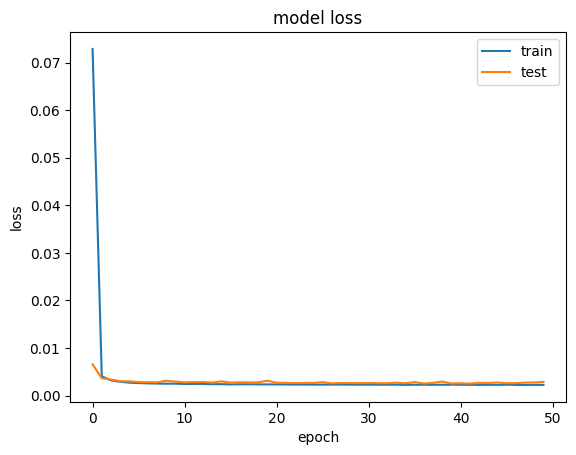

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')


In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
y_pred=model.predict(X_test)
test_predict=model.predict(X_test)
print(test_predict.shape)
predictions_original_scale = scalar.inverse_transform(test_predict)
y_test_original_scale = scalar.inverse_transform(y_test)
# mae=mean_absolute_error(predictions_original_scale,y_test_original_scale,)
# mse=np.sqrt(mean_squared_error(predictions_original_scale,y_test_original_scale,))
# mape=mean_absolute_percentage_error(predictions_original_scale,y_test_original_scale,)
# rmse=np.sqrt(mse)
# print(rmse)
# print(mse)
# print(mae)
# print(mape)

143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
(4562, 2)
3.584047446692455
12.845396100142706
7.283453674091158
0.3612464514325814


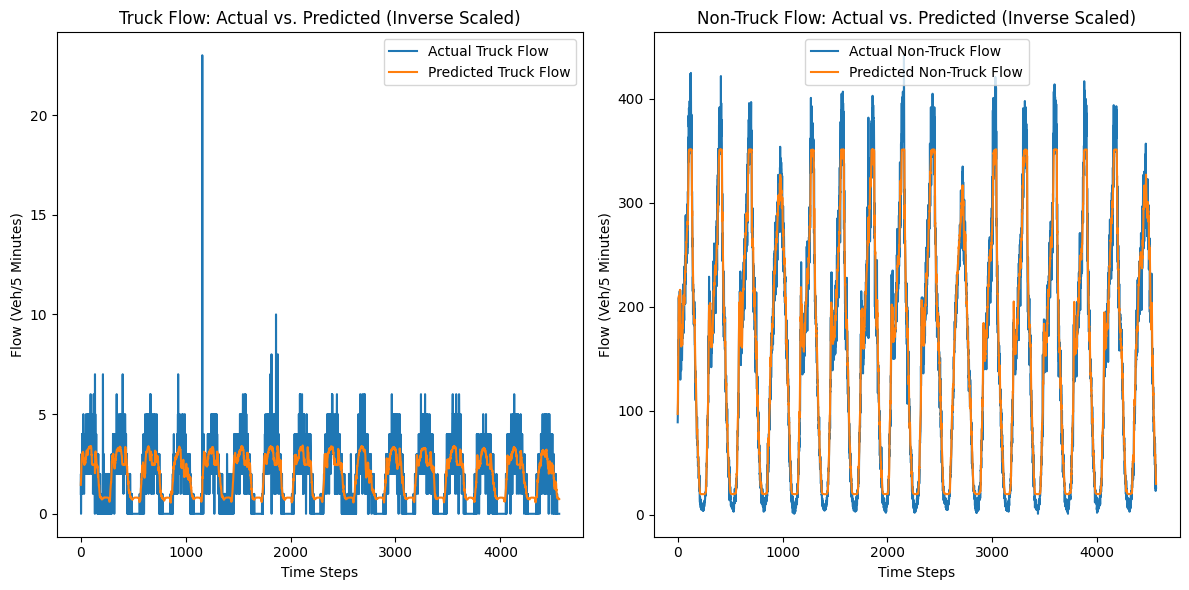

--- Metrics for Truck Flow (Original Scale) ---
RMSE: 1.0471
MAE: 0.8248
MAPE (masked): 35.72%

--- Metrics for Non-Truck Flow (Original Scale) ---
RMSE: 18.1359
MAE: 13.7421
MAPE (masked): 33.32%


In [ ]:

# import matplotlib.pyplot as plt
# plt.figure(figsize=(12, 6))

# #  Truck Flow
# plt.subplot(1, 2, 1)
# plt.plot(y_test_original_scale[:, 0], label='Actual Truck Flow')
# plt.plot(predictions_original_scale[:, 0], label='Predicted Truck Flow')
# plt.title('Truck Flow: Actual vs. Predicted (Inverse Scaled)')
# plt.xlabel('Time Steps')
# plt.ylabel('Flow (Veh/5 Minutes)')
# plt.legend()

# # Non-Truck Flow
# plt.subplot(1, 2, 2)
# plt.plot(y_test_original_scale[:, 1] , label='Actual Non-Truck Flow')
# plt.plot(predictions_original_scale[:, 1], label='Predicted Non-Truck Flow')
# plt.title('Non-Truck Flow: Actual vs. Predicted (Inverse Scaled)')
# plt.xlabel('Time Steps')
# plt.ylabel('Flow (Veh/5 Minutes)')
# plt.legend()

# plt.tight_layout()
# plt.show()

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.figure(figsize=(12, 6))

#  Truck Flow
plt.subplot(1, 2, 1)
plt.plot(y_test_original_scale[:, 0], label='Actual Truck Flow')
plt.plot(predictions_original_scale[:, 0], label='Predicted Truck Flow')
plt.title('Truck Flow: Actual vs. Predicted (Inverse Scaled)')
plt.xlabel('Time Steps')
plt.ylabel('Flow (Veh/5 Minutes)')
plt.legend()

# Non-Truck Flow
plt.subplot(1, 2, 2)
plt.plot(y_test_original_scale[:, 1], label='Actual Non-Truck Flow')
plt.plot(predictions_original_scale[:, 1], label='Predicted Non-Truck Flow')
plt.title('Non-Truck Flow: Actual vs. Predicted (Inverse Scaled)')
plt.xlabel('Time Steps')
plt.ylabel('Flow (Veh/5 Minutes)')
plt.legend()

plt.tight_layout()
plt.show()

# --- Truck Flow ---
actual_truck_flow = y_test_original_scale[:, 0]
predicted_truck_flow = predictions_original_scale[:, 0]

rmse_truck = np.sqrt(mean_squared_error(actual_truck_flow, predicted_truck_flow))
mae_truck = mean_absolute_error(actual_truck_flow, predicted_truck_flow)

# Masked MAPE
mask_truck = actual_truck_flow != 0
mape_truck = np.mean(
    np.abs((actual_truck_flow[mask_truck] - predicted_truck_flow[mask_truck]) / actual_truck_flow[mask_truck])
) * 100

print(f"--- Metrics for Truck Flow (Original Scale) ---")
print(f"RMSE: {rmse_truck:.4f}")
print(f"MAE: {mae_truck:.4f}")
print(f"MAPE (masked): {mape_truck:.2f}%")

# --- Non-Truck Flow ---
actual_non_truck_flow = y_test_original_scale[:, 1]
predicted_non_truck_flow = predictions_original_scale[:, 1]

rmse_non_truck = np.sqrt(mean_squared_error(actual_non_truck_flow, predicted_non_truck_flow))
mae_non_truck = mean_absolute_error(actual_non_truck_flow, predicted_non_truck_flow)

# Masked MAPE
mask_non_truck = actual_non_truck_flow != 0
mape_non_truck = np.mean(
    np.abs((actual_non_truck_flow[mask_non_truck] - predicted_non_truck_flow[mask_non_truck]) / actual_non_truck_flow[mask_non_truck])
) * 100

print(f"\n--- Metrics for Non-Truck Flow (Original Scale) ---")
print(f"RMSE: {rmse_non_truck:.4f}")
print(f"MAE: {mae_non_truck:.4f}")
print(f"MAPE (masked): {mape_non_truck:.2f}%")

In [ ]:
# import tensorflow as tf

# # === Load the saved MLP model ===
# mlp_model = tf.keras.models.load_model('gru_model.keras', compile=False)

# # === Set up the TFLite converter ===
# converter = tf.lite.TFLiteConverter.from_keras_model(mlp_model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16]
# converter.target_spec.supported_ops = [
#     tf.lite.OpsSet.TFLITE_BUILTINS,
#     tf.lite.OpsSet.SELECT_TF_OPS
# ]
# converter._experimental_lower_tensor_list_ops = False  # Optional (needed for RNNs, not MLP)

# # === Convert to TFLite model ===
# tflite_model = converter.convert()

# # === Save the quantized model ===
# with open('gru_model_quant.tflite', 'wb') as f:
#     f.write(tflite_model)




In [ ]:
# from google.colab import files

# # Download the quantized model
# files.download("gru_model_quant.tflite")